In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy.stats import f


file_path = "logistic_1.xlsx"
df = pd.read_excel(file_path)

df_clean = df[["Selling Price", "Discount Percentage", "Return"]].copy()
df_clean.replace([np.inf, -np.inf], np.nan, inplace=True)
df_clean.dropna(inplace=True)


X = df_clean[["Selling Price", "Discount Percentage"]]
X = sm.add_constant(X)
y = df_clean["Return"]


if y.nunique() < 2:
    raise ValueError("Target variable 'Return' has only one class!")

logit_model = sm.Logit(y, X)
result = logit_model.fit()


print("\n--- LOGISTIC REGRESSION SUMMARY ---")
print(result.summary())


n = len(y)
p = X.shape[1]
r_squared = 1 - result.llf / result.llnull
adj_r_squared = 1 - (1 - r_squared) * (n - 1) / (n - p - 1)
std_error = np.sqrt(np.sum(result.resid_response**2) / (n - p))

# Print Regression Statistics
print("\n--- REGRESSION STATISTICS ---")
print(f"Multiple R: {np.sqrt(r_squared):.4f}")
print(f"R Square: {r_squared:.4f}")
print(f"Adjusted R Square: {adj_r_squared:.4f}")
print(f"Standard Error: {std_error:.4f}")
print(f"Observations: {n}")

# Compute Deviance (ANOVA Equivalent for Logistic Regression)
deviance_regression = result.llnull - result.llf
deviance_residual = -2 * result.llf
total_deviance = -2 * result.llnull


df_regression = X.shape[1] - 1
df_residual = len(y) - X.shape[1]
df_total = len(y) - 1

# Compute Mean Square (MS)
ms_regression = deviance_regression / df_regression if df_regression > 0 else np.nan
ms_residual = deviance_residual / df_residual if df_residual > 0 else np.nan

# Compute F-statistic
F_stat = ms_regression / ms_residual if ms_residual > 0 else np.nan
p_value_f = 1 - f.cdf(F_stat, df_regression, df_residual) if F_stat > 0 else np.nan

# Print ANOVA Table
print("\n--- ANOVA TABLE ---")
anova_table = pd.DataFrame({
    "df": [df_regression, df_residual, df_total],
    "Deviance": [deviance_regression, deviance_residual, total_deviance],
    "MS": [ms_regression, ms_residual, None],
    "F": [F_stat, None, None],
    "Significance F": [p_value_f, None, None]
}, index=["Regression", "Residual", "Total"])
print(anova_table)


coefs = result.params
std_err = result.bse
t_stats = coefs / std_err
p_values = result.pvalues
conf_int = result.conf_int(0.05)

# Print Coefficient Table
print("\n--- COEFFICIENTS TABLE ---")
coeff_table = pd.DataFrame({
    "Coefficient": coefs,
    "Standard Error": std_err,
    "t-Stat": t_stats,
    "P-value": p_values,
    "Lower 95%": conf_int[0],
    "Upper 95%": conf_int[1]
})
print(coeff_table)


Optimization terminated successfully.
         Current function value: 0.689671
         Iterations 4

--- LOGISTIC REGRESSION SUMMARY ---
                           Logit Regression Results                           
Dep. Variable:                 Return   No. Observations:                 5672
Model:                          Logit   Df Residuals:                     5669
Method:                           MLE   Df Model:                            2
Date:                Thu, 03 Apr 2025   Pseudo R-squ.:                0.002072
Time:                        11:26:13   Log-Likelihood:                -3911.8
converged:                       True   LL-Null:                       -3919.9
Covariance Type:            nonrobust   LLR p-value:                 0.0002966
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.1482      0.189      0.782 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


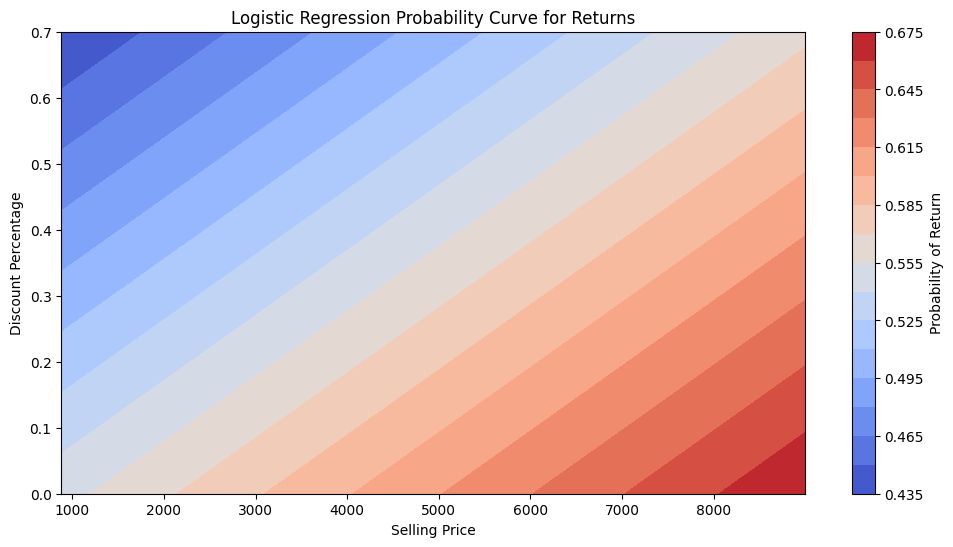

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression


df = pd.read_excel("logistic_1.xlsx")


df = df.dropna(subset=['Selling Price', 'Discount Percentage', 'Return'])


df['Return'] = (df['Return'] >= 0.5).astype(int)


X = df[['Selling Price', 'Discount Percentage']]
y = df['Return']


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


model = LogisticRegression()
model.fit(X_scaled, y)


selling_price_range = np.linspace(df['Selling Price'].min(), df['Selling Price'].max(), 100)
discount_range = np.linspace(df['Discount Percentage'].min(), df['Discount Percentage'].max(), 100)

sp_grid, dp_grid = np.meshgrid(selling_price_range, discount_range)


X_pred = np.c_[sp_grid.ravel(), dp_grid.ravel()]
X_pred_scaled = scaler.transform(X_pred)

# Predict probabilities
probabilities = model.predict_proba(X_pred_scaled)[:, 1]
probabilities = probabilities.reshape(sp_grid.shape)

# Plot
plt.figure(figsize=(12, 6))
contour = plt.contourf(sp_grid, dp_grid, probabilities, levels=20, cmap='coolwarm')
plt.colorbar(contour, label="Probability of Return")

plt.xlabel("Selling Price")
plt.ylabel("Discount Percentage")
plt.title("Logistic Regression Probability Curve for Returns")

plt.show()
